# Experiment 3: Smoothed Support Vector Classifer on Iris Dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from importlib import reload
from mlxtend.plotting import plot_decision_regions
import influence
reload(influence)

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from influence.plot_utils import param_cross_comparison
from influence.closed_forms import I_loss_RidgeCf
from models.regularized_regression import RegularizedRegression
from models.hyperplane_clf import BinaryLogisticRegression
from models.hyperplane_clf import SmoothedSupportVector

/Users/zed/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# [6, 47]
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.Iris, test_config=[6, 21])
n_tr, p = X_train.shape
n_te, _ = X_test.shape
y_train[y_train==0]=-1 
y_test[y_test==0]=-1
print(n_tr, p)

init_eta = 1e-2
batch_size = 50
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=20000
iter_to_switch_to_sgd=40000
C = 1.0
t = 0.01
# LOO a on random set of training indices, otherwise too slow
leave_indices = None
#assert not set(test_indices) & set(leave_indices)
#print(test_indices)
print(leave_indices)

X_train shape: (98, 4)
y_train shape: (98, 1)
X_test shape: (2, 4)
y_test shape: (2, 1)
98 4
None


In [3]:
tf.reset_default_graph()
model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=t
)

model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 1.00000000 (0.203 sec)
Step 1000, Epoch 510: loss = 0.27224565 (0.000 sec)
Step 2000, Epoch 1020: loss = 0.22598094 (0.000 sec)
Step 3000, Epoch 1530: loss = 0.30882984 (0.000 sec)
Step 4000, Epoch 2040: loss = 0.26576000 (0.000 sec)
Step 5000, Epoch 2551: loss = 0.35319319 (0.000 sec)
Step 6000, Epoch 3061: loss = 0.31962553 (0.000 sec)
Step 7000, Epoch 3571: loss = 0.25851783 (0.000 sec)
Step 8000, Epoch 4081: loss = 0.32225898 (0.000 sec)
Step 9000, Epoch 4591: loss = 0.28012919 (0.000 sec)
Step 10000, Epoch 5102: loss = 0.35511491 (0.000 sec)
Step 11000, Epoch 5612: loss = 0.29815972 (0.000 sec)
Step 12000, Epoch 6122: loss = 0.26249430 (0.000 sec)
Step 13000, Epoch 6632: loss = 0.23722024 (0.000 sec)
Step 14000, Epoch 7142: loss = 0.29101732 (0.000 sec)
Step 15000, Epoch 7653: loss = 0.31068969 (0.000 sec)
Step 16000, Epoch 8163: loss = 0.33485574 (0.000 sec)
Step 17000, Epoch 8673: loss = 0.27192271 (0.000 sec)
Step 18000, Epoch 9183: loss = 0.27824754 (0.

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.01)

In [4]:
y_pred = model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/n_tr)

Train accuracy: 0.9489795918367347


In [5]:
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force',
)
# I_loss_bf[leave_indices,:]/n_tr

Fetch training loss gradients (0.188 sec)


In [6]:
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg',
    tol=1e-7, 
    max_iter=1000
)

Fetch training loss gradients (0.094 sec)
         Current function value: -0.968663
         Iterations: 5
         Function evaluations: 70
         Gradient evaluations: 63
         Hessian evaluations: 12
         Current function value: -0.016954
         Iterations: 2
         Function evaluations: 81
         Gradient evaluations: 71
         Hessian evaluations: 11


In [7]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
)

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 0: loss = 0.28993389 (3.064 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 9: loss = 0.28942961 (3.610 sec)
INFO:tensorflow:Restoring parameters from outp

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 90: loss = 0.28993389 (3.906 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999


In [9]:
print(leave_indices)
print(I_loss_bf[leave_indices,:]/n_tr)
print(loo_diff)

None
[[[-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [ 4.58593271e-03 -1.19009736e-03]
  [ 3.24995360e-03 -7.32155175e-04]
  [ 1.59304239e-02 -9.17921261e-04]
  [-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [ 1.49435863e-02 -4.90065740e-05]
  [ 3.50311581e-03 -2.16734835e-03]
  [-6.84915757e-04  3.45942545e-04]
  [-6.85630100e-04  3.45998881e-04]
  [ 1.44466004e-02 -1.15412291e-03]
  [-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [ 1.91763056e-02  4.02227956e-04]
  [-6.85630100e-04  3.45998881e-04]
  [-4.28636950e-03 -1.16956356e-03]
  [-6.85630100e-04  3.45998881e-04]
  [ 1.88779028e-02  1.67638063e-03]
  [ 2.94797396e-03 -7.72631898e-04]
  [ 1.42537246e-02 -2.19429269e-03]
  [-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [ 9.39603728e-03 -7.02556299e-04]
  [ 1.36155571e-02 -6.98629691e-04]
  [-6.85630100e-04  3.4

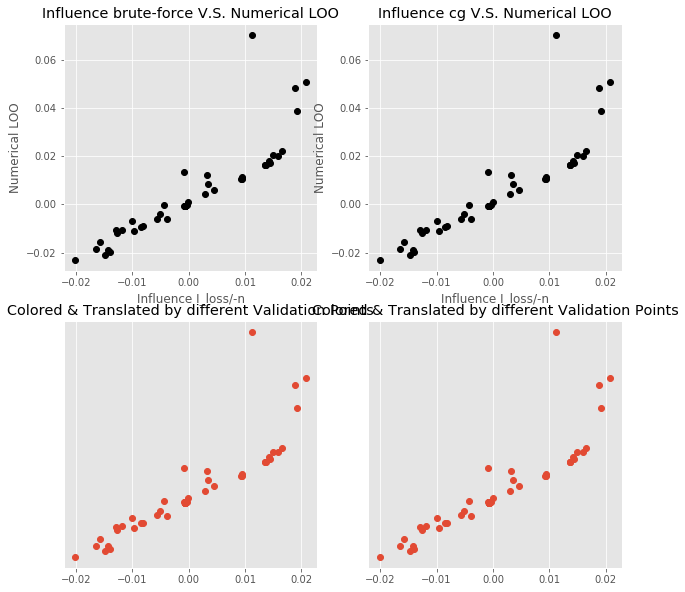

In [8]:
fig, axes = compare_with_loo(
    [I_loss_bf[:,0:1],
     I_loss_cg[:,0:1]],
    loo_diff, n_samples=n_tr
)

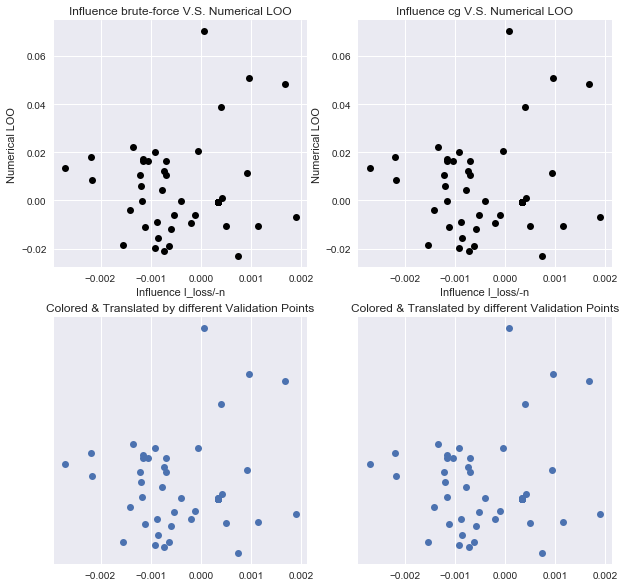

In [11]:
fig, axes = compare_with_loo(
    [I_loss_bf[:,1:2],
     I_loss_cg[:,1:2]],
    loo_diff, n_samples=n_tr
)

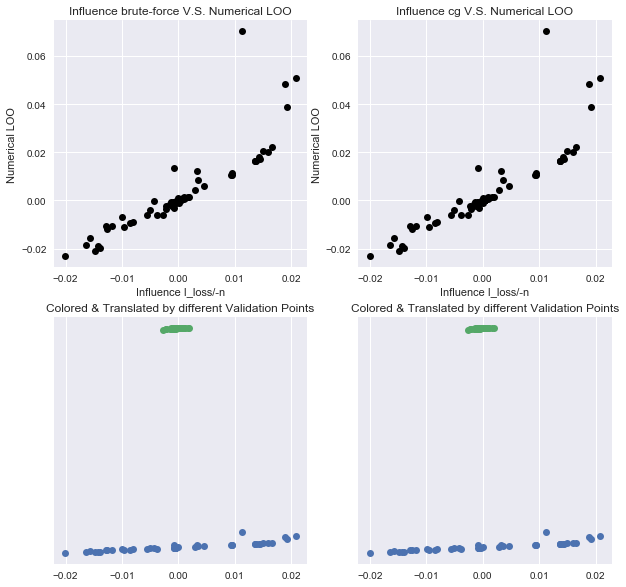

In [11]:
fig, axes = compare_with_loo(
    [I_loss_bf,
     I_loss_cg],
    loo_diff, n_samples=n_tr
)

In [12]:
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_cg[:, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_cg[:, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.8705
Test Point 1 Correlation: 0.9103
Overall Correlation: 0.8654


# Smooth Hinge with different t

# t = 0

In [4]:
tf.reset_default_graph()
model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0
)
model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 1.00000000 (0.095 sec)
Step 1000, Epoch 510: loss = 0.31809786 (0.002 sec)
Step 2000, Epoch 1020: loss = 0.28150302 (0.002 sec)
Step 3000, Epoch 1530: loss = 0.28448567 (0.001 sec)
Step 4000, Epoch 2040: loss = 0.23962966 (0.001 sec)
Step 5000, Epoch 2551: loss = 0.30934581 (0.001 sec)
Step 6000, Epoch 3061: loss = 0.28166485 (0.001 sec)
Step 7000, Epoch 3571: loss = 0.28820771 (0.001 sec)
Step 8000, Epoch 4081: loss = 0.30197620 (0.001 sec)
Step 9000, Epoch 4591: loss = 0.32625103 (0.001 sec)
Step 10000, Epoch 5102: loss = 0.25766838 (0.002 sec)
Step 11000, Epoch 5612: loss = 0.23343016 (0.001 sec)
Step 12000, Epoch 6122: loss = 0.29052666 (0.001 sec)
Step 13000, Epoch 6632: loss = 0.29549325 (0.001 sec)
Step 14000, Epoch 7142: loss = 0.26844612 (0.001 sec)
Step 15000, Epoch 7653: loss = 0.30052796 (0.001 sec)
Step 16000, Epoch 8163: loss = 0.30757543 (0.001 sec)
Step 17000, Epoch 8673: loss = 0.35317773 (0.002 sec)
Step 18000, Epoch 9183: loss = 0.32038334 (0.

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0)

In [5]:
I_loss_bf1 = model.influence_loss(
    X_test, y_test,
    method='brute-force',
)

loo_diff1 = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
)

Fetch training loss gradients (0.168 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 0: loss = 0.28961560 (3.839 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 9: loss = 0.28923634 (4.499 sec)
INFO

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 90: loss = 0.28961560 (4.659 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999


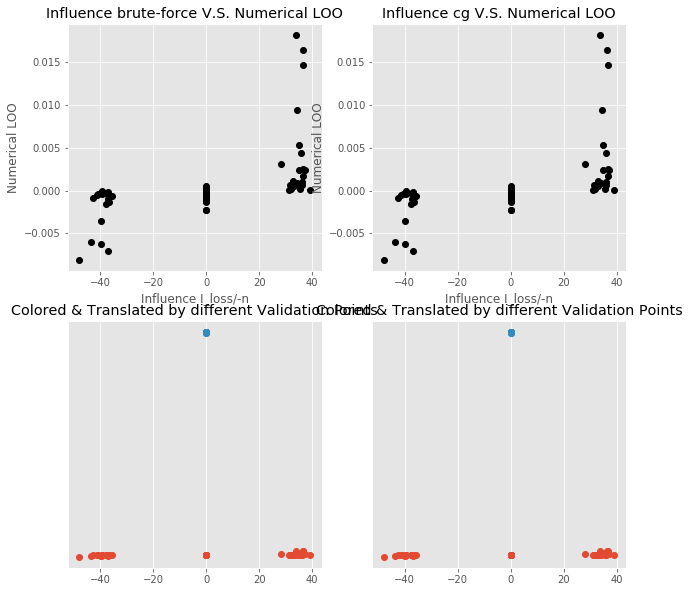

In [15]:
fig, axes = compare_with_loo(
    [I_loss_bf1, I_loss_bf1],
    loo_diff1, n_samples=n_tr
)

# t = 0.1

In [6]:
tf.reset_default_graph()
model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0.1
)
model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 1.00000465 (0.094 sec)
Step 1000, Epoch 510: loss = 0.29432261 (0.016 sec)
Step 2000, Epoch 1020: loss = 0.28952560 (0.000 sec)
Step 3000, Epoch 1530: loss = 0.29696313 (0.016 sec)
Step 4000, Epoch 2040: loss = 0.31056762 (0.000 sec)
Step 5000, Epoch 2551: loss = 0.30291662 (0.000 sec)
Step 6000, Epoch 3061: loss = 0.32882249 (0.000 sec)
Step 7000, Epoch 3571: loss = 0.33752346 (0.000 sec)
Step 8000, Epoch 4081: loss = 0.29507053 (0.000 sec)
Step 9000, Epoch 4591: loss = 0.27603331 (0.000 sec)
Step 10000, Epoch 5102: loss = 0.29358786 (0.016 sec)
Step 11000, Epoch 5612: loss = 0.36402234 (0.000 sec)
Step 12000, Epoch 6122: loss = 0.25745389 (0.000 sec)
Step 13000, Epoch 6632: loss = 0.31257120 (0.000 sec)
Step 14000, Epoch 7142: loss = 0.32030606 (0.000 sec)
Step 15000, Epoch 7653: loss = 0.27664563 (0.000 sec)
Step 16000, Epoch 8163: loss = 0.34129703 (0.000 sec)
Step 17000, Epoch 8673: loss = 0.30240399 (0.000 sec)
Step 18000, Epoch 9183: loss = 0.28883407 (0.

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.1)

In [7]:
I_loss_bf2 = model.influence_loss(
    X_test, y_test,
    method='brute-force',
)

loo_diff2 = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
)

Fetch training loss gradients (0.141 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 0: loss = 0.29889524 (3.360 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 9: loss = 0.29767463 (4.012 sec)
INFO

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 90: loss = 0.29889277 (4.278 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999


range(0, 2)


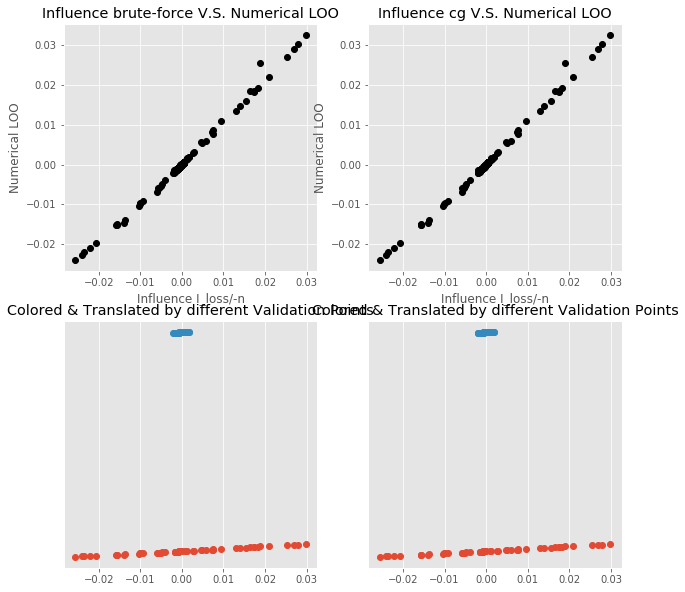

In [18]:
fig, axes = compare_with_loo(
    [I_loss_bf2, I_loss_bf2],
    loo_diff2, n_samples=n_tr
)

# t = 0.01

In [8]:
tf.reset_default_graph()
model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0.01
)
model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 1.00000000 (0.144 sec)
Step 1000, Epoch 510: loss = 0.29301760 (0.002 sec)
Step 2000, Epoch 1020: loss = 0.34586459 (0.000 sec)
Step 3000, Epoch 1530: loss = 0.24556035 (0.001 sec)
Step 4000, Epoch 2040: loss = 0.26977620 (0.002 sec)
Step 5000, Epoch 2551: loss = 0.32673973 (0.000 sec)
Step 6000, Epoch 3061: loss = 0.21591349 (0.002 sec)
Step 7000, Epoch 3571: loss = 0.29131290 (0.000 sec)
Step 8000, Epoch 4081: loss = 0.27580222 (0.002 sec)
Step 9000, Epoch 4591: loss = 0.24406262 (0.000 sec)
Step 10000, Epoch 5102: loss = 0.28516605 (0.002 sec)
Step 11000, Epoch 5612: loss = 0.24268717 (0.000 sec)
Step 12000, Epoch 6122: loss = 0.26719379 (0.000 sec)
Step 13000, Epoch 6632: loss = 0.35406274 (0.002 sec)
Step 14000, Epoch 7142: loss = 0.30939564 (0.002 sec)
Step 15000, Epoch 7653: loss = 0.31789359 (0.001 sec)
Step 16000, Epoch 8163: loss = 0.31441075 (0.001 sec)
Step 17000, Epoch 8673: loss = 0.30355510 (0.000 sec)
Step 18000, Epoch 9183: loss = 0.31068787 (0.

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.01)

In [9]:
I_loss_bf3 = model.influence_loss(
    X_test, y_test,
    method='brute-force',
)

Fetch training loss gradients (0.242 sec)


In [10]:
loo_diff3 = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
)

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 0: loss = 0.28993380 (4.993 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 9: loss = 0.28942961 (4.170 sec)
INFO:tensorflow:Restoring parameters from outp

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 90: loss = 0.28993383 (3.063 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999


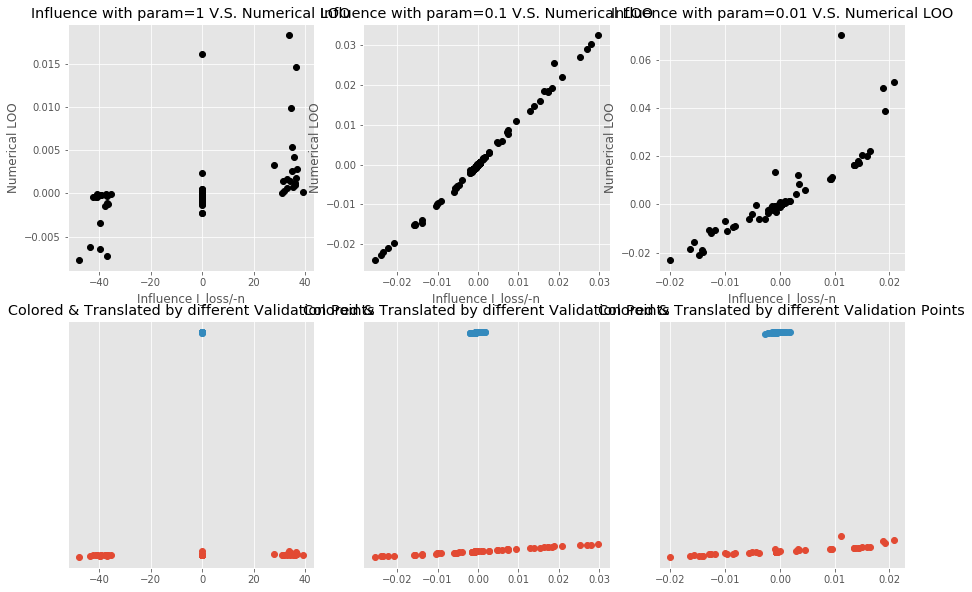

In [41]:
fig, axes = param_cross_comparison(
    [I_loss_bf1, I_loss_bf2, I_loss_bf3],
    [loo_diff1, loo_diff2, loo_diff3], n_tr, [1, 0.1, 0.01]
)

# Influence function application

## Vanilla

In [2]:
df = pd.read_csv('data/hyperplane_2.csv')
n = len(df)
X_vanilla = df.values[:, 0:2]
y_vanilla = df.values[:, -1].reshape(n, 1)
n, p = X_vanilla.shape

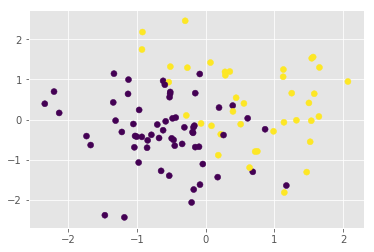

In [56]:
plt.scatter(X_vanilla[:,0], X_vanilla[:,1], c=y_vanilla[:,0])

In [61]:
tf.reset_default_graph()

init_eta = 1e-2
batch_size = 40
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=20000
iter_to_switch_to_sgd=40000
C = 1.0
t = 0
leave_indices = None
print(leave_indices)

model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=t
)
model.fit(
    X_vanilla, y_vanilla,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

None
Step 0, Epoch 0: loss = 1.00000000 (0.129 sec)
Step 1000, Epoch 400: loss = 0.90320569 (0.001 sec)
Step 2000, Epoch 800: loss = 0.77111202 (0.001 sec)
Step 3000, Epoch 1200: loss = 0.80412847 (0.001 sec)
Step 4000, Epoch 1600: loss = 0.74742919 (0.001 sec)
Step 5000, Epoch 2000: loss = 0.75009531 (0.001 sec)
Step 6000, Epoch 2400: loss = 0.66249055 (0.001 sec)
Step 7000, Epoch 2800: loss = 0.69412100 (0.001 sec)
Step 8000, Epoch 3200: loss = 0.77452767 (0.001 sec)
Step 9000, Epoch 3600: loss = 0.74211615 (0.001 sec)
Step 10000, Epoch 4000: loss = 0.75479352 (0.001 sec)
Step 11000, Epoch 4400: loss = 0.79446650 (0.002 sec)
Step 12000, Epoch 4800: loss = 0.70830232 (0.002 sec)
Step 13000, Epoch 5200: loss = 0.78873652 (0.002 sec)
Step 14000, Epoch 5600: loss = 0.79677331 (0.002 sec)
Step 15000, Epoch 6000: loss = 0.64701521 (0.001 sec)
Step 16000, Epoch 6400: loss = 0.87257689 (0.001 sec)
Step 17000, Epoch 6800: loss = 0.83896351 (0.001 sec)
Step 18000, Epoch 7200: loss = 0.77661848

SmoothHinge-Notebook(init_eta=0.01,batch_size=40,decay_epochs=(10000, 20000),C=1.0,t=0)

In [62]:
I_loss_bf4 = model.influence_loss(
    X_vanilla, y_vanilla,
    method='brute-force',
)

Fetch training loss gradients (0.288 sec)


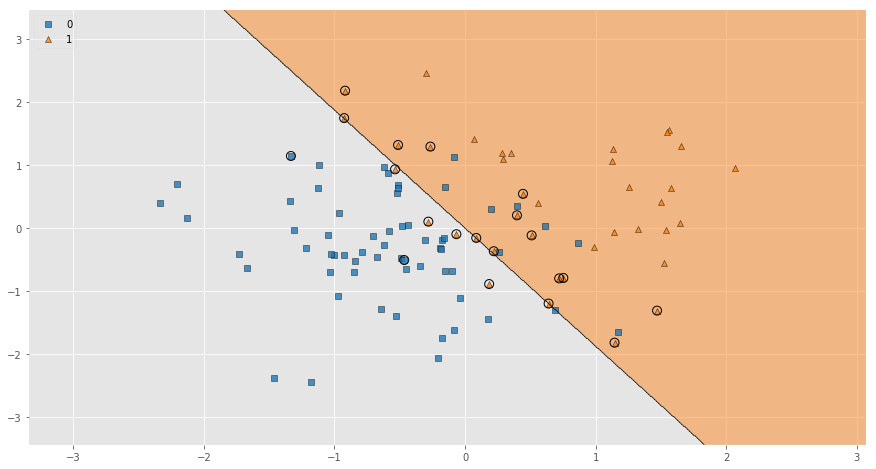

In [64]:
fig,_ = plt.subplots(figsize=(15,8))
abs_mean_i_loss = np.abs(sum(I_loss_bf4)/sum(sum(I_loss_bf4)))
plot_decision_regions(X_vanilla, y_vanilla.astype(int).reshape(100,), X_highlight=X_vanilla[np.argsort(-abs_mean_i_loss)[0:20]], clf=model, legend=2)

## Iris

In [139]:
tf.reset_default_graph()

# [6, 47]
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.Iris, test_config=0.2)
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print(n_tr, p)

X_train shape: (80, 4)
y_train shape: (80, 1)
X_test shape: (20, 4)
y_test shape: (20, 1)
80 4


In [140]:
init_eta = 1e-2
batch_size = 50
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=20000
iter_to_switch_to_sgd=40000
C = 1.0
t = 0.01
# LOO a on random set of training indices, otherwise too slow
leave_indices = None
#assert not set(test_indices) & set(leave_indices)
#print(test_indices)
print(leave_indices)

model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0.1
)
model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

None
Step 0, Epoch 0: loss = 1.00000465 (0.104 sec)
Step 1000, Epoch 624: loss = 0.46070844 (0.001 sec)
Step 2000, Epoch 1249: loss = 0.50069886 (0.002 sec)
Step 3000, Epoch 1874: loss = 0.58066374 (0.001 sec)
Step 4000, Epoch 2499: loss = 0.56068963 (0.001 sec)
Step 5000, Epoch 3124: loss = 0.54069090 (0.001 sec)
Step 6000, Epoch 3749: loss = 0.44072878 (0.001 sec)
Step 7000, Epoch 4374: loss = 0.50070959 (0.001 sec)
Step 8000, Epoch 4999: loss = 0.56066710 (0.001 sec)
Step 9000, Epoch 5624: loss = 0.52071398 (0.002 sec)
Step 10000, Epoch 6249: loss = 0.54065973 (0.002 sec)
Step 11000, Epoch 6874: loss = 0.54069173 (0.001 sec)
Step 12000, Epoch 7499: loss = 0.50067079 (0.001 sec)
Step 13000, Epoch 8124: loss = 0.60066491 (0.001 sec)
Step 14000, Epoch 8749: loss = 0.54069841 (0.002 sec)
Step 15000, Epoch 9374: loss = 0.56069410 (0.001 sec)
Step 16000, Epoch 9999: loss = 0.52069455 (0.001 sec)
Step 17000, Epoch 10624: loss = 0.52067548 (0.001 sec)
Step 18000, Epoch 11249: loss = 0.62065

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.1)

In [5]:
I_loss_bf5 = model.influence_loss(
    X_train, y_train,
    method='brute-force',
)
mean_i_loss = sum(I_loss_bf5)/sum(sum(I_loss_bf5))

Fetch training loss gradients (0.109 sec)


Text(0,0.5,'Mean Influence loss')

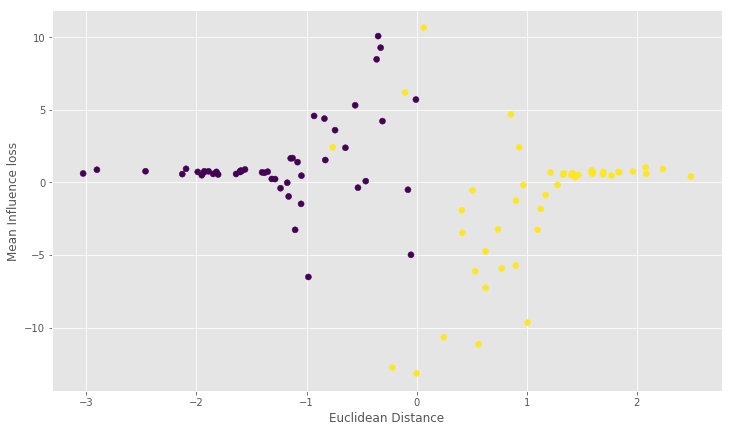

In [48]:
fig,axis = plt.subplots(figsize = (12,7))
beta = model.get_eval(items=['params'])['beta']
euclidean_dist = X_train.dot(beta)
plt.scatter(euclidean_dist.flatten(), mean_i_loss, c=y_train[:,0])
plt.xlabel('Euclidean Distance')
plt.ylabel('Mean Influence loss')

# Logistic Regression vs SVM

In [109]:
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.Iris, test_config=10)
n_tr, p = X_train.shape
n_te, _ = X_test.shape
y_train[y_train==0]=-1 
y_test[y_test==0]=-1
print(n_tr, p)

X_train shape: (90, 4)
y_train shape: (90, 1)
X_test shape: (10, 4)
y_test shape: (10, 1)
90 4


In [112]:
tf.reset_default_graph()

y_train[y_train==0]=-1
y_test[y_test==0]=-1

init_eta = 1e-2
batch_size = 50
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=20000
iter_to_switch_to_sgd=40000
C = 1.0
t = 0.01
# LOO a on random set of training indices, otherwise too slow
leave_indices = None
#assert not set(test_indices) & set(leave_indices)
#print(test_indices)
print(leave_indices)

svm_model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0.1
)
svm_model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

None
Step 0, Epoch 0: loss = 1.00000465 (0.111 sec)
Step 1000, Epoch 555: loss = 0.30897868 (0.001 sec)
Step 2000, Epoch 1111: loss = 0.30993798 (0.003 sec)
Step 3000, Epoch 1666: loss = 0.32204312 (0.001 sec)
Step 4000, Epoch 2222: loss = 0.33504471 (0.001 sec)
Step 5000, Epoch 2777: loss = 0.37150222 (0.001 sec)
Step 6000, Epoch 3333: loss = 0.32921806 (0.001 sec)
Step 7000, Epoch 3888: loss = 0.28502113 (0.001 sec)
Step 8000, Epoch 4444: loss = 0.30315116 (0.001 sec)
Step 9000, Epoch 4999: loss = 0.27730700 (0.001 sec)
Step 10000, Epoch 5555: loss = 0.29063639 (0.001 sec)
Step 11000, Epoch 6111: loss = 0.28237659 (0.001 sec)
Step 12000, Epoch 6666: loss = 0.30889386 (0.001 sec)
Step 13000, Epoch 7222: loss = 0.31599426 (0.001 sec)
Step 14000, Epoch 7777: loss = 0.25198480 (0.001 sec)
Step 15000, Epoch 8333: loss = 0.29013535 (0.001 sec)
Step 16000, Epoch 8888: loss = 0.29345155 (0.001 sec)
Step 17000, Epoch 9444: loss = 0.31172702 (0.001 sec)
Step 18000, Epoch 9999: loss = 0.2724437

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.1)

In [113]:
y_pred = svm_model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/n_tr)

y_pred_test = svm_model.predict(X_test)
print("Test accuracy:", np.sum(y_pred_test == y_test)/len(y_test))

Train accuracy: 0.9666666666666667
Test accuracy: 0.9


In [114]:
I_loss_bf_svm = svm_model.influence_loss(
    X_test, y_test,
    method='brute-force',
)
mean_i_loss_svm = sum(I_loss_bf_svm)

Fetch training loss gradients (0.049 sec)


In [115]:
tf.reset_default_graph()

y_train[y_train==-1]=0
y_test[y_test==-1]=0

init_eta = 0.01
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
leave_indices = None

if hasattr(test_indices, '__iter__') and hasattr(leave_indices, '__iter__'):
    assert not set(test_indices) & set(leave_indices)
    print(test_indices)
    print(leave_indices)

blr_model = BinaryLogisticRegression(
    model_name='BinaryLogistic-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=10.0
)


"""
blr_model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)
"""

blr_model.fit_with_sklearn(
    {'X':X_train, 'y':y_train}
)


Model Evaluations:
------------------------------------------
Empirical Risk: 0.650175
Norm of Params: 1.232589
Norm of Gradient: 0.136954


BinaryLogistic-Notebook(init_eta=0.01,batch_size=30,decay_epochs=(10000, 20000),C=10.0)

In [116]:
y_pred = blr_model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/len(y_train))

y_pred_test = blr_model.predict(X_test)
print("Test accuracy:", np.sum(y_pred_test == y_test)/len(y_test))

Train accuracy: 0.9444444444444444
Test accuracy: 0.9


In [117]:
I_loss_bf_blr = blr_model.influence_loss(
    X_test, y_test,
    method='brute-force',
)
mean_i_loss_blr = sum(I_loss_bf_blr)

Fetch training loss gradients (0.043 sec)


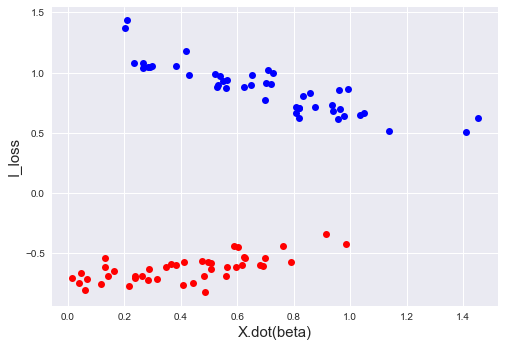

In [122]:
for i in range(1):
    plt.plot(np.abs(X_train.dot(beta_blr))[y_train==1], 
            I_loss_bf_blr[:,i:i+1][y_train==1], 'o', color='red')
    plt.plot(np.abs(X_train.dot(beta_blr))[y_train==0], 
            I_loss_bf_blr[:,i:i+1][y_train==0], 'o', color='blue')
plt.xlabel('X.dot(beta)', fontsize=15)
plt.ylabel('I_loss', fontsize=15)

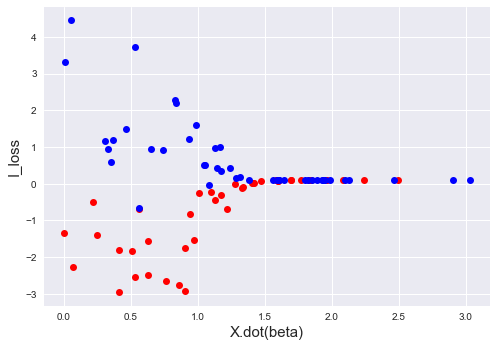

In [121]:
for i in range(1):
    plt.plot(np.abs(X_train.dot(beta_svm))[y_train==1], 
            I_loss_bf_svm[:,i:i+1][y_train==1], 'o', color='red')
    plt.plot(np.abs(X_train.dot(beta_svm))[y_train==0], 
            I_loss_bf_svm[:,i:i+1][y_train==0], 'o', color='blue')
plt.xlabel('X.dot(beta)', fontsize=15)
plt.ylabel('I_loss', fontsize=15)

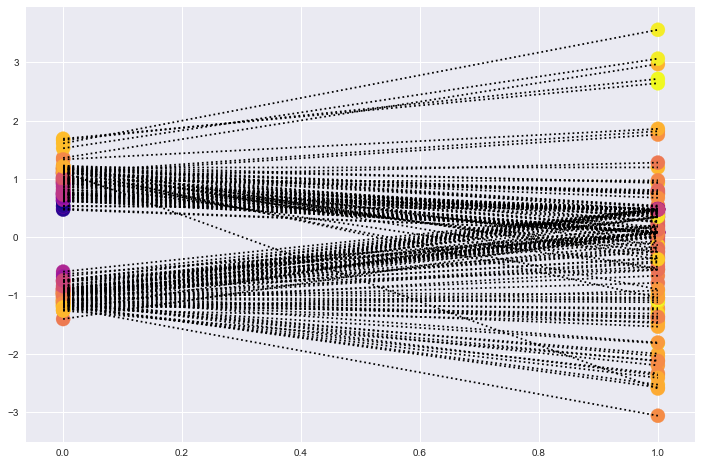

In [134]:
fig, ax = plt.subplots(figsize=(12,8))

beta_blr = blr_model.get_eval(items=['params'])['beta']
euclidean_dist_blr = StandardScaler().fit_transform(
    abs(X_train.dot(beta_blr)))

beta_svm = svm_model.get_eval(items=['params'])['beta']
euclidean_dist_svm = StandardScaler().fit_transform(
    abs(X_train.dot(beta_svm)))

"""
for i in range(80):
    norm_iloss_blr = StandardScaler().fit_transform(I_loss_bf_blr[:,i:i+1])
    norm_iloss_svm = StandardScaler().fit_transform(I_loss_bf_svm[:,i:i+1])
    plt.scatter(np.zeros(len(mean_i_loss_blr)),
            norm_iloss_blr, c = -euclidean_dist_blr[:,0],
            cmap=plt.get_cmap('viridis'), s=200)
    plt.scatter(np.ones(len(mean_i_loss_svm)),
                norm_iloss_svm, c = -euclidean_dist_svm[:,0],
                cmap=plt.get_cmap('viridis'), s=200)
"""



for i in range(2):
    norm_iloss_blr = StandardScaler().fit_transform(
        I_loss_bf_blr[:,i:i+1])
    norm_iloss_svm = StandardScaler().fit_transform(
        I_loss_bf_svm[:,i:i+1])
    plt.scatter(np.zeros(n_tr),
                norm_iloss_blr, c = -euclidean_dist_blr[:,0],
                cmap=plt.get_cmap('plasma'), s=200)
    plt.scatter(np.ones(n_tr),
                norm_iloss_svm, c = -euclidean_dist_svm[:,0],
                cmap=plt.get_cmap('plasma'), s=200)


    for i in range(len(norm_iloss_blr)):
        plt.plot([0,1], [norm_iloss_blr[i], norm_iloss_svm[i]], 'k:')

In [184]:
df = pd.DataFrame({'influence':norm_iloss_svm, 'distance':euclidean_dist_svm[:,0]})
# df.groupby(pd.cut(df["distance"], np.arange(-1, 3, 0.1))).sum()

In [183]:
df = pd.DataFrame({'influence':norm_iloss_blr, 'distance':euclidean_dist_blr[:,0]})
# df.groupby(pd.cut(df["distance"], np.arange(0, 3, 0.1))).sum()

In [151]:
beta1 = blr_model.get_eval(items=['params'])['beta']
beta2 = svm_model.get_eval(items=['params'])['beta']
print(beta1,beta2)

[[ 1.2242963]
 [ 1.296414 ]
 [-1.7951735]
 [-1.6542718]] [[0.16816868]
 [0.08068632]
 [0.1128763 ]
 [0.03594271]]
